# Titanic Kaggle Competition

## Overview of this project
- We will get the data
- Explore it
- Write pipelines for data imputation, scaling and OrdinalEncoding/ OneHotEncoding of categorical features
- Train a RandomForestClassifier and Support Vector Machine
- Apply RandomizedSearchCV hyperparameter tuning for a better accuracy score, evaluated using cross-validation-score
- Visualise the models performance

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Get the data

In [4]:
#!kaggle competitions download -c titanic

In [5]:
#!unzip titanic.zip

In [6]:
test_data = pd.read_csv('test.csv')
train_data = pd.read_csv('train.csv')
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:

- PassengerId: a unique identifier for each passenger
- Survived: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
- Pclass: passenger class.
- Name, Sex, Age: self-explanatory
- SibSp: how many siblings & spouses of the passenger aboard the Titanic.
- Parch: how many children & parents of the passenger aboard the Titanic.
- Ticket: ticket id
- Fare: price paid (in pounds)
- Cabin: passenger's cabin number
- Embarked: where the passenger embarked the Titanic

The goal is to predict whether or not a passenger survived based on attributes such as their age, sex, passenger class, where they embarked and so on.

In [7]:
train_data = train_data.set_index('PassengerId')
test_data = test_data.set_index('PassengerId')

In [8]:
# Inspect the data
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      891 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


In [9]:
# Get the percentage of null values
#len(train_data)

columns_with_na = ['Age', 'Cabin', 'Embarked']

for column in columns_with_na:
    percent_missing = float(train_data[column].isnull().sum() / len(train_data)) * 100
    print(f"{np.round(percent_missing,2)}% of data is missing in the column: {column}")

19.87% of data is missing in the column: Age
77.1% of data is missing in the column: Cabin
0.22% of data is missing in the column: Embarked


Steps to remember for missing values: Replace NA with the median Age.

Notes: **Name** and **Ticket** might be tricky to convert into useful numbers so that a model can consume it.

In [10]:
# Numerical attributes
train_data.describe()

,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


Only 38% survived - accuracy will be a reasonable metric to evaluate the model 

Let's check the target is actually 0 or 1:

In [11]:
train_data['Survived'].value_counts()

Survived
0    549
1    342
Name: count, dtype: int64

Let's inspect all categorical attributes:

In [12]:
cat_features = ['Pclass', 'Sex', 'Embarked']

for cat in cat_features:
    print(train_data[cat].value_counts())
    print('\n---------------------------\n')

Pclass
3    491
1    216
2    184
Name: count, dtype: int64

---------------------------

Sex
male      577
female    314
Name: count, dtype: int64

---------------------------

Embarked
S    644
C    168
Q     77
Name: count, dtype: int64

---------------------------



The Embarked attribute tells us where the passengers embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

Let's build preprocessing pipelines, starting with the pipeline for numerical attributes:

In [13]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

Pipeline for categorical features:

In [14]:
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
cat_pipeline = Pipeline([
    ('ordinal_encoder', OrdinalEncoder()),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('cat_encoder', OneHotEncoder(sparse_output=False)),
])

Let's join the numerical and categorical pipelines:

In [15]:
from sklearn.compose import ColumnTransformer
num_attribs = ['Age', 'SibSp', 'Parch', 'Fare']
cat_attribs = ['Pclass', 'Sex', 'Embarked']

preprocess_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', cat_pipeline, cat_attribs),
])

We can now feed out training data into the pipeline.

In [16]:
X_train = preprocess_pipeline.fit_transform(train_data)
X_train

array([[-0.56573646,  0.43279337, -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       [ 0.66386103,  0.43279337, -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [-0.1046374 ,  0.43279337,  2.00893337, ...,  0.        ,
         0.        ,  1.        ],
       [-0.25833709, -0.4745452 , -0.47367361, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.20276197, -0.4745452 , -0.47367361, ...,  0.        ,
         1.        ,  0.        ]])

Add the labels:

In [17]:
y_train = train_data["Survived"]

Let's now train the classifier `RandomForestClassifier`:

In [18]:
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

We can use our model to make predictions now.

In [19]:
X_test = preprocess_pipeline.transform(test_data)
y_pred = forest_clf.predict(X_test)

Let's use cross-validation to see how well our model performed!

In [20]:
from sklearn.model_selection import cross_val_score

forest_scores_1 = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores_1.mean()

np.float64(0.8115230961298376)

Why cross validation?
- Instead of using a single train-test split, k-fold cross-validation (here, cv=10) divides the dataset into 10 subsets (folds).
- The model (forest_clf) is trained on 9 folds and tested on the remaining 1 fold.
- This process is repeated 10 times, with each fold serving as the test set exactly once
- After 10 iterations, you get 10 different validation scores.
- The mean of these scores (forest_scores.mean()) represents the overall model performance

- Reduces bias and variance issues
- Helps detect overfitting

Let's try RandomizedSearchCV to further improve the model.

In [21]:
from sklearn.model_selection import RandomizedSearchCV
params = {
    'n_estimators': np.arange(50, 500, 50), # Ramdom trees from 50 to 450
    'max_depth': [10, 20, 30, None],    # Tree depth
    'min_samples_split': [2, 5, 10], # Minimum samples for a split
    'min_samples_leaf': [1, 2, 5, 10],   # Minimum samples in a leaf
    'max_features': ['sqrt', 'log2', None], # Feature seleciton
    'bootstrap': [True, False], # Bootstrap sampling
    'criterion': ['gini', 'entropy'] # Split criteria
}

In [22]:
random_search = RandomizedSearchCV(RandomForestClassifier(random_state=42),  # Algorithm
                                   param_distributions=params,  # Parameter
                                   n_iter=40,  # Number of random combinations to test
                                   cv=10,    # 10-fold cross-validation
                                   n_jobs=-1,    # Use all GPU cores
                                   #verbose=2,  # Logging Output (More detailed logs)
                                   random_state=42)

In [23]:
random_search.fit(X_train, y_train)
print("Best Parameters:", random_search.best_params_)

Best Parameters: {'n_estimators': np.int64(400), 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': None, 'max_depth': 10, 'criterion': 'entropy', 'bootstrap': True}


In [24]:
random_search.best_estimator_.fit(X_train, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, max_features=None,
                       min_samples_split=5, n_estimators=np.int64(400),
                       random_state=42)

In [25]:
rf_y_pred2 = random_search.best_estimator_.predict(X_test)
forest_scores_2 = cross_val_score(random_search.best_estimator_, X_train, y_train, cv=10, n_jobs=9)
forest_scores_2.mean()

np.float64(0.8406616729088638)

In [26]:
test_data.reset_index(inplace=True)

In [27]:
# Submission1 for Kaggle:
submission_rf = pd.DataFrame({
    'PassengerID': test_data['PassengerId'],
    'Survived': rf_y_pred2
})

import os
desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'submission_rf.csv')

submission_rf.to_csv(desktop_path, index=False)

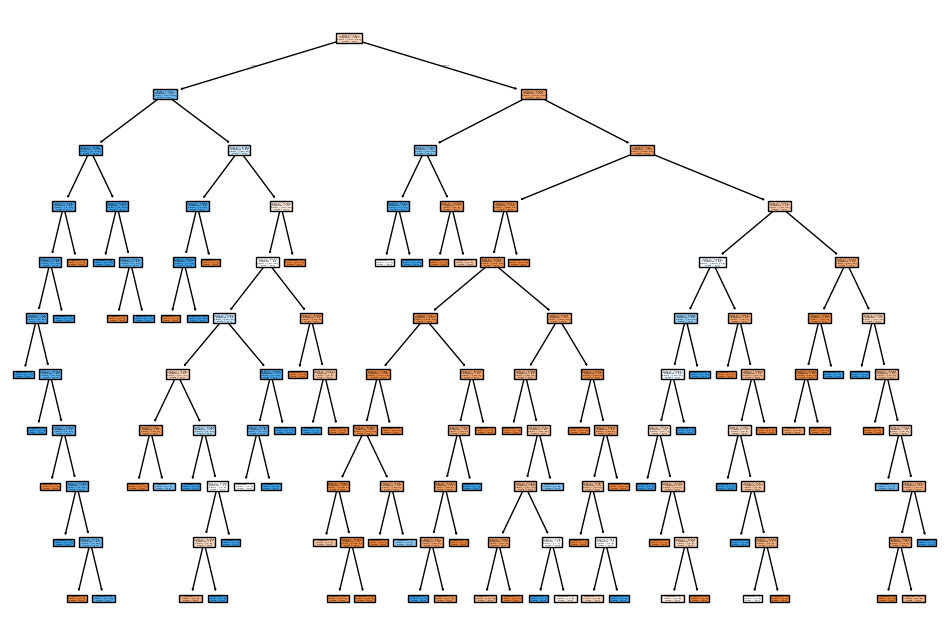

In [28]:
# Plot the Classifier
from sklearn.tree import plot_tree
best_tree = random_search.best_estimator_.estimators_[0]
# Plot
plt.figure(figsize=(12,8))
plot_tree(best_tree, filled=True, class_names=True)
plt.show()

## SVC

Let's try an SVC instead:

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma='auto', random_state=42)
svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

np.float64(0.8249313358302123)

In [30]:
# Let's do a prediction using SVC
svm_clf.fit(X_train, y_train)
svm_predict = svm_clf.predict(X_test)

In [31]:
# Submission2 for Kaggle:
submission_svm = pd.DataFrame({
    'PassengerID': test_data['PassengerId'],
    'Survived': svm_predict
})

desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'submission_svm.csv')

submission_svm.to_csv(desktop_path, index=False)

Let's also try to improve the performance using RandomizedSearchCV:

In [32]:
svm_params = {
    'C': np.logspace(-2, 2, 5),
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4],
}

In [33]:
# This will run several minutes!
svm_random_search = RandomizedSearchCV(SVC(), param_distributions=svm_params,
                                       n_iter=200,
                                       cv=10,
                                       n_jobs=-1,
                                       random_state=42)
svm_random_search.fit(X_train, y_train)
print("Best Parameters:", svm_random_search.best_params_)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 90 is smaller than n_iter=200. Running 90 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best Parameters: {'kernel': 'poly', 'gamma': 'scale', 'degree': 2, 'C': np.float64(10.0)}


In [34]:
# Fit the best parameter
svm_random_search.best_estimator_.fit(X_train, y_train)

SVC(C=np.float64(10.0), degree=2, kernel='poly')

In [35]:
svm_y_pred2 = svm_random_search.best_estimator_.predict(X_test)

In [36]:
# Submission3 for Kaggle:
submission_svm_opt = pd.DataFrame({
    'PassengerID': test_data['PassengerId'],
    'Survived': svm_y_pred2
})

desktop_path = os.path.join(os.path.expanduser('~'), 'Desktop', 'submission_svm_opt.csv')

submission_svm_opt.to_csv(desktop_path, index=False)

In [37]:
svm_scores2 = cross_val_score(svm_random_search.best_estimator_, X_train, y_train, cv=10, n_jobs=5)
svm_scores2.mean()

np.float64(0.832784019975031)

We plot all the Accuracy cross-validation results:

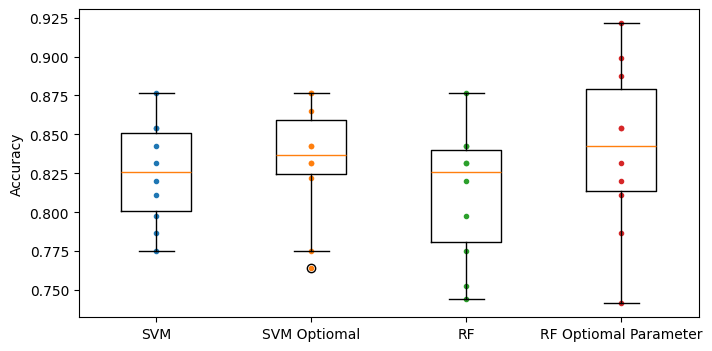

In [38]:
# Let's plot the performance
plt.figure(figsize=(8,4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, svm_scores2, ".")
plt.plot([3]*10, forest_scores_1, ".")
plt.plot([4]*10, forest_scores_2, ".")
plt.boxplot([svm_scores,svm_scores2, forest_scores_1, forest_scores_2], tick_labels=("SVM","SVM Optiomal", "RF", "RF Optiomal Parameter"))
plt.ylabel("Accuracy")
plt.show()